In [1]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [10]:
# Collecting Words
path = '/content/drive/MyDrive/Colab Notebooks/AndrejKarpathy_NN_Hero/names.txt'
words = open(path, 'r').read().splitlines()

# Mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [29]:
block_size = 3 # number of characters as input
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

# Split the dataset (train: 80%, dev: 10%, test:10%)
rs = 2147483647
torch.manual_seed(42); # for reproduceability
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, train_size=0.8, random_state=rs, shuffle=True)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp, Y_temp, train_size=0.5, random_state=rs, shuffle=True)

### Pytorchify Code: Add more classes and club layers into Sequential

In [49]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

# Clubbing Multiple Layers into a Container

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [50]:
n_embd = 10 # dimensionality of the embedding vectors
n_hidden = 200 # neurons in the hidden layer
vocab_size = 27

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [51]:
batch_size = 32
itrns = 200000
lossi = []

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ))
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())

print("Final Loss: ", loss.item())

Loss on iteration 0: 3.2935924530029297 | Learning Rate: 0.1
Loss on iteration 10000: 2.29407000541687 | Learning Rate: 0.1
Loss on iteration 20000: 1.7902637720108032 | Learning Rate: 0.1
Loss on iteration 30000: 2.1642794609069824 | Learning Rate: 0.1
Loss on iteration 40000: 2.1873393058776855 | Learning Rate: 0.1
Loss on iteration 50000: 2.114886999130249 | Learning Rate: 0.1
Loss on iteration 60000: 2.0209755897521973 | Learning Rate: 0.1
Loss on iteration 70000: 2.0486178398132324 | Learning Rate: 0.1
Loss on iteration 80000: 2.5024943351745605 | Learning Rate: 0.1
Loss on iteration 90000: 2.294386386871338 | Learning Rate: 0.1
Loss on iteration 100000: 1.882494330406189 | Learning Rate: 0.1
Loss on iteration 110000: 2.1629228591918945 | Learning Rate: 0.1
Loss on iteration 120000: 2.0981831550598145 | Learning Rate: 0.1
Loss on iteration 130000: 1.984136700630188 | Learning Rate: 0.1
Loss on iteration 140000: 2.0123836994171143 | Learning Rate: 0.1
Loss on iteration 150000: 2.36

In [53]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False

# DEV & TEST LOSS
@torch.no_grad() # decorator to disable grad tracking for any vars inside the function
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.114558219909668
test 2.1130573749542236


In [54]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mona.
kayah.
seel.
ndhonalee.
thruthadrieg.
azeled.
elin.
shi.
jen.
eden.
estanaraelyzion.
kamin.
shub.
rishiriel.
kin.
renlynn.
novana.
ubakynder.
yarue.
eli.


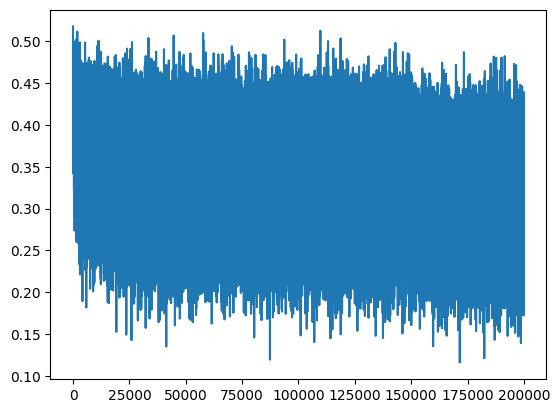

In [55]:
plt.plot(lossi)

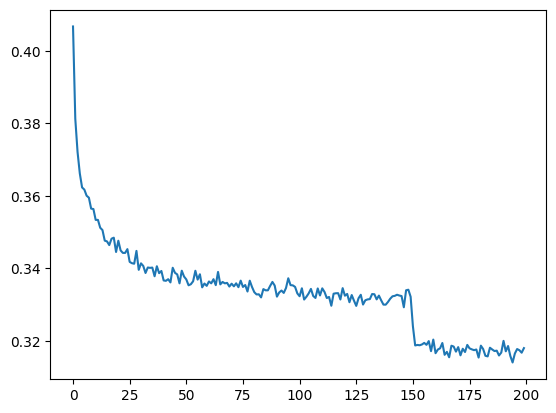

In [56]:
# the loss looks too oscillating, no clear pattern
# let's take the mean of each 1000 iterations's loss logs

plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

### Dilated Causal Convolutional layers

Let's use 8 characters as input, and instead of squashing them into an equation in a single layer, let's do it progressively, 2 characters at a time

![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%2Fid%2FOIP.SwYimoeSeEA2vxum9bP_jgHaDl%3Fr%3D0%26pid%3DApi&f=1&ipt=0cd9b51e641c98dbd5df9a0a242822b0bb0aad3b3ebd11ea6112b4b04c3102ae&ipo=images)

In [57]:
block_size = 8 # number of characters as input
X, Y = [], []

for w in words:
    context = [0] * block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

# Split the dataset (train: 80%, dev: 10%, test:10%)
rs = 2147483647
torch.manual_seed(42); # for reproduceability
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, train_size=0.8, random_state=rs, shuffle=True)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp, Y_temp, train_size=0.5, random_state=rs, shuffle=True)

In [60]:
n_embd = 10 # dimensionality of the embedding vectors
n_hidden = 200 # neurons in the hidden layer
vocab_size = 27

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22097


In [61]:
batch_size = 32
itrns = 200000
lossi = []

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ))
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())

print("Final Loss: ", loss.item())

Loss on iteration 0: 3.3169336318969727 | Learning Rate: 0.1
Loss on iteration 10000: 2.5022454261779785 | Learning Rate: 0.1
Loss on iteration 20000: 2.447808027267456 | Learning Rate: 0.1
Loss on iteration 30000: 2.334378480911255 | Learning Rate: 0.1
Loss on iteration 40000: 2.164828062057495 | Learning Rate: 0.1
Loss on iteration 50000: 2.0723536014556885 | Learning Rate: 0.1
Loss on iteration 60000: 2.169372797012329 | Learning Rate: 0.1
Loss on iteration 70000: 1.9889376163482666 | Learning Rate: 0.1
Loss on iteration 80000: 1.8500629663467407 | Learning Rate: 0.1
Loss on iteration 90000: 1.6178162097930908 | Learning Rate: 0.1
Loss on iteration 100000: 1.8165514469146729 | Learning Rate: 0.1
Loss on iteration 110000: 2.108165740966797 | Learning Rate: 0.1
Loss on iteration 120000: 2.414097547531128 | Learning Rate: 0.1
Loss on iteration 130000: 2.149364709854126 | Learning Rate: 0.1
Loss on iteration 140000: 2.1517157554626465 | Learning Rate: 0.1
Loss on iteration 150000: 2.122

In [62]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False

# DEV & TEST LOSS
@torch.no_grad() # decorator to disable grad tracking for any vars inside the function
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.0325732231140137
test 2.032092809677124


In [63]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mohani.
yazziel.
madyn.
alareth.
stendra.
grazeem.
melin.
shyloe.
leighsen.
anarielle.
malaia.
noshaber.
shiriel.
kindreel.
konnie.
casuma.
geda.
jamell.
elsyla.
jayson.


Performance Log
- Original (context: 3 chars + 200 hidden neurons, 12K params): train- 2.18, val-2.114, test-2.113
- context: 3->8 (22k params): train-2.28, val-2.03, test-2.03

In [65]:
# We want to club together 2 characters in each level
# let's take an example of what we are currently doing in our Linear layer
# eg: take 4 inputs, 8 characters * 10 dimensional vectors = 80 dimensions, 200 hidden neurons in first layer
emb = torch.randn(4, 80)
wet = torch.randn(80, 200)
bis = torch.randn(200)
(emb @ wet + bis).shape

torch.Size([4, 200])

In [70]:
# instead of squashing like that, now we will take only a combination of 2 characters, 20 dimensional vectors in each layer
emb = torch.randn(4, 8, 10)

l1 = (emb.view(4, -1, 20) @ torch.randn(20, 200) + torch.randn(200))
print('l1: ', l1.shape)

l1:  torch.Size([4, 4, 200])


In [74]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutiveN:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# Clubbing Multiple Layers into a Container

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [75]:
n_embd = 10 # dimensionality of the embedding vectors
n_hidden = 200 # neurons in the hidden layer
vocab_size = 27

model = Sequential([
    Embedding(vocab_size, n_embd), # 4, 8, 10
    FlattenConsecutiveN(block_size), # 4, 80
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22097


In [76]:
ix = torch.randint(low=0, high=X_train.shape[0], size=(4, ))
Xb, Yb = X_train[ix], Y_train[ix]
logits = model(Xb)

print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 18,  8,  5, 20, 20],
        [ 0,  0,  0,  0,  0,  0,  0, 20],
        [ 0,  0,  0,  0,  0,  0,  1, 14],
        [ 0,  0,  0, 19, 15, 14,  1, 13]])

In [77]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutiveN : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


#### Update the consecutive N size

In [94]:
n_embd = 10 # dimensionality of the embedding vectors
n_hidden = 68 # neurons in the hidden layer
vocab_size = 27

model = Sequential([
    Embedding(vocab_size, n_embd), # 4, 8, 10
    FlattenConsecutiveN(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutiveN(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutiveN(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22397


In [95]:
ix = torch.randint(low=0, high=X_train.shape[0], size=(4, ))
Xb, Yb = X_train[ix], Y_train[ix]
logits = model(Xb)

print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 10,  1, 13,  9, 12],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  9, 25,  1, 14]])

In [96]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutiveN : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutiveN : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutiveN : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [97]:
batch_size = 32
itrns = 200000
lossi = []

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ))
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())

print("Final Loss: ", loss.item())

Loss on iteration 0: 3.2879951000213623 | Learning Rate: 0.1
Loss on iteration 10000: 1.9877878427505493 | Learning Rate: 0.1
Loss on iteration 20000: 1.6482698917388916 | Learning Rate: 0.1
Loss on iteration 30000: 2.16200852394104 | Learning Rate: 0.1
Loss on iteration 40000: 1.9285345077514648 | Learning Rate: 0.1
Loss on iteration 50000: 2.2006118297576904 | Learning Rate: 0.1
Loss on iteration 60000: 1.6384074687957764 | Learning Rate: 0.1
Loss on iteration 70000: 2.066401481628418 | Learning Rate: 0.1
Loss on iteration 80000: 1.9437100887298584 | Learning Rate: 0.1
Loss on iteration 90000: 2.096543788909912 | Learning Rate: 0.1
Loss on iteration 100000: 1.828500509262085 | Learning Rate: 0.1
Loss on iteration 110000: 1.9100549221038818 | Learning Rate: 0.1
Loss on iteration 120000: 2.579824447631836 | Learning Rate: 0.1
Loss on iteration 130000: 2.1416876316070557 | Learning Rate: 0.1
Loss on iteration 140000: 2.4631359577178955 | Learning Rate: 0.1
Loss on iteration 150000: 2.63

In [98]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False

# DEV & TEST LOSS
@torch.no_grad() # decorator to disable grad tracking for any vars inside the function
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.038123846054077
test 2.0357651710510254


In [99]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

montaymyah.
seelen.
hayla.
rensrette.
raege.
zehed.
eliah.
miloe.
leighnes.
anarielle.
malaia.
noshub.
rilai.
jestin.
joselynn.
novalfou.
zenne.
ruyah.
faeli.
kayshis.


In [100]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (1, 8, 10)
FlattenConsecutiveN : (1, 4, 20)
Linear : (1, 4, 68)
BatchNorm1d : (1, 4, 68)
Tanh : (1, 4, 68)
FlattenConsecutiveN : (1, 2, 136)
Linear : (1, 2, 68)
BatchNorm1d : (1, 2, 68)
Tanh : (1, 2, 68)
FlattenConsecutiveN : (1, 136)
Linear : (1, 68)
BatchNorm1d : (1, 68)
Tanh : (1, 68)
Linear : (1, 27)


Performance Log

- Original (context: 3 chars + 200 hidden neurons, 12K params): train- 2.18, val-2.114, test-2.113
- context: 3->8 (22k params): train-2.28, val-2.03, test-2.03
- hierarchical-dilated: 2 consecutive numbers(22k params): train-2.16 , val-2.03 , test- 2.03

#### Debugging BatchNorm to take 3d tensors as input

In [101]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim ==2:
                dims_reduce = 0
            elif x.ndim ==3:
                dims_reduce = (0, 1)
            xmean = x.mean(dims_reduce, keepdim=True) # batch mean
            xvar = x.var(dims_reduce, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutiveN:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

# Clubbing Multiple Layers into a Container

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [102]:
n_embd = 10 # dimensionality of the embedding vectors
n_hidden = 68 # neurons in the hidden layer
vocab_size = 27

model = Sequential([
    Embedding(vocab_size, n_embd), # 4, 8, 10
    FlattenConsecutiveN(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutiveN(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutiveN(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22397


In [105]:
batch_size = 32
itrns = 200000
lossi = []

for i in range(itrns):
    # minibatch
    ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size, ))
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # nudge
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'Loss on iteration {i}: {loss.item()} | Learning Rate: {lr}')
    lossi.append(loss.log10().item())

print("Final Loss: ", loss.item())

Loss on iteration 0: 3.2976396083831787 | Learning Rate: 0.1
Loss on iteration 10000: 2.2582876682281494 | Learning Rate: 0.1
Loss on iteration 20000: 2.0415730476379395 | Learning Rate: 0.1
Loss on iteration 30000: 1.936320424079895 | Learning Rate: 0.1
Loss on iteration 40000: 1.800300121307373 | Learning Rate: 0.1
Loss on iteration 50000: 1.9813306331634521 | Learning Rate: 0.1
Loss on iteration 60000: 1.8723562955856323 | Learning Rate: 0.1
Loss on iteration 70000: 2.033402442932129 | Learning Rate: 0.1
Loss on iteration 80000: 1.9158909320831299 | Learning Rate: 0.1
Loss on iteration 90000: 2.1224076747894287 | Learning Rate: 0.1
Loss on iteration 100000: 1.6351393461227417 | Learning Rate: 0.1
Loss on iteration 110000: 2.3161938190460205 | Learning Rate: 0.1
Loss on iteration 120000: 1.7075954675674438 | Learning Rate: 0.1
Loss on iteration 130000: 1.497706651687622 | Learning Rate: 0.1
Loss on iteration 140000: 1.9173574447631836 | Learning Rate: 0.1
Loss on iteration 150000: 2.

In [106]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False

# DEV & TEST LOSS
@torch.no_grad() # decorator to disable grad tracking for any vars inside the function
def split_loss(split):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_dev, Y_dev),
        'test': (X_test, Y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.030392646789551
test 2.022149085998535


In [107]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mordal.
yazlee.
lendyn.
alareth.
stejgra.
graden.
daelin.
shivoph.
edelieana.
arleigh.
malara.
noshub.
roshimae.
trinio.
jenil.
novaleiu.
zayven.
jamell.
eliyah.
jayston.


In [108]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (1, 8, 10)
FlattenConsecutiveN : (1, 4, 20)
Linear : (1, 4, 68)
BatchNorm1d : (1, 4, 68)
Tanh : (1, 4, 68)
FlattenConsecutiveN : (1, 2, 136)
Linear : (1, 2, 68)
BatchNorm1d : (1, 2, 68)
Tanh : (1, 2, 68)
FlattenConsecutiveN : (1, 136)
Linear : (1, 68)
BatchNorm1d : (1, 68)
Tanh : (1, 68)
Linear : (1, 27)


Performance Log

- Original (context: 3 chars + 200 hidden neurons, 12K params): train- 2.18, val-2.114, test-2.113
- context: 3->8 (22k params): train-2.28, val-2.03, test-2.03
- hierarchical-dilated: 2 consecutive numbers(22k params): train-2.16 , val-2.03 , test- 2.03
- BatchNorm for 3D tensors (22k params): train- , val-, test-